In [162]:
%matplotlib inline

import numpy as np
from pyprimal import Dantzig
import matplotlib
import matplotlib.pyplot as plt
import math
import cvxpy as cp
#pip install pyprimal

# Causal Dantzig 复现


## 简单数据集 
### 直接求Inverse

数据生成
此处的causal factor为第二个factor对应index是1

In [163]:
def simple_dataset():
    n = 1000
    eta = np.random.multivariate_normal(mean = np.zeros((5,)), cov=np.eye(5), size=(n,))
    
    sigma = [0, 1, 4]
    
    data ={}
    for i in [1, 2]:
        data['X'+ str(i)] = np.zeros((n,3))
        data['Y'+ str(i)]  = np.zeros((n,1))
        data['X'+ str(i)][:,1] = eta[:, 0] + sigma[i] * eta[:, 3]
        data['Y'+ str(i)] = data['X'+ str(i)][:,1] + eta[:, 0] +eta[:, 1] 
        data['X'+ str(i)][:,0] = data['Y'+ str(i)].ravel() +  data['X'+ str(i)][:,1] + sigma[i] * eta[:, 2]
        data['X'+ str(i)][:,2] =  data['X'+ str(i)][:,0]  +   eta[:, 0] + sigma[i] * eta[:, 4]
    return data

Dantzig $\beta=G^{-1}Z$

In [164]:
class Unregularized_Dantzig(object):
    def __init__(self, X1, Y1, X2, Y2):
       
        self.X1=X1
        self.Y1=Y1
        self.X2=X2
        self.Y2=Y2
        assert(len(self.X1)==len(self.Y1))
        assert(len(self.X2)==len(self.Y2))
        self.env_num=2
        
    def solve(self):
        ## cal gram matrix 
        G = np.matmul(self.X1.transpose(), self.X1)/len(self.X1) -  np.matmul(self.X2.transpose(), self.X2)/len(self.X2)
        Z = np.matmul(self.X1.transpose(), self.Y1)/len(self.X1) -  np.matmul(self.X2.transpose(), self.Y2)/len(self.X2)
        beta = np.matmul(np.linalg.inv(G), Z)
        print(((Z - np.matmul(G, beta))**2 / 2).sum())
        return beta
        

求解

In [165]:
data = simple_dataset()
unreg_dangtzig = Unregularized_Dantzig(X1=data['X1'], Y1=data['Y1'],X2=data['X2'], Y2=data['Y2'])
beta = unreg_dangtzig.solve()
print('Weight : ', beta)

5.064487011518896e-28
Weight :  [ 2.83552476e-03  9.92465488e-01 -8.00929938e-04]


## 高维数据
$min \|\beta \|_1 \quad s.t. \quad \| Z-G\beta\|_{\infty} \leq \lambda$

数据生成
此处的causal factor为第二个factor对应index是1

In [166]:
def high_dim_dataset(n=100, p=200):
    eta = np.random.randn(n,p)
    delta = np.random.randn(n,p)*2.5
    etay =  np.random.randn(n,)
    data ={}
    data['X1'] = np.zeros((n,p))
    data['Y1']  = np.zeros((n,1))
    data['X2'] = np.zeros((n,p))
    data['Y2']  = np.zeros((n,1))
    
    data['X1'][:, 0] = eta[:, 0]
    data['X2'][:, 0] = eta[:, 0] +delta[:, 0]
    
    data['X1'][:, 1] = eta[:, 1] +data['X1'][:, 0] 
    data['X2'][:, 1] = eta[:, 1] +data['X2'][:, 0] + delta[:, 1]

    data['Y1']  =data['X1'][:, 1] + etay
    data['Y2']  = data['X2'][:, 1] + etay    
    data['X1'][:, 2] = eta[:, 2] +data['Y1']
    data['X2'][:, 2] = eta[:, 2] +data['Y2'] + delta[:, 2]
    
    for k in range(3, p):
        data['X1'][:, k] = eta[:, k] +data['X1'][:, k-1] 
        data['X2'][:, k] = eta[:, k] +data['X2'][:, k-1] +  delta[:, k]
        
    return data

Dantzig求解

In [167]:
class Regularized_Dantzig(object):
    def __init__(self, X1, Y1, X2, Y2):
        mean = np.mean(np.vstack([X1, X2]), 0)
        mean_y = np.mean(np.vstack([Y1, Y2]), 0)
        X1, X2 = X1-mean, X2-mean
        Y1, Y2 = Y1-mean_y, Y2-mean_y
        scale =   np.sqrt(np.mean(X1**2, 0)) +  np.sqrt(np.mean(X2**2, 0))
        scale /= 2
        self.X1=X1/scale
        self.Y1=Y1
        self.X2=X2/scale
        self.Y2=Y2
    def solve(self):
        G = np.matmul(self.X1.transpose(), self.X1)/len(self.X1) -  np.matmul(self.X2.transpose(), self.X2)/len(self.X2)
        Z = np.matmul(self.X1.transpose(), self.Y1)/len(self.X1) -  np.matmul(self.X2.transpose(), self.Y2)/len(self.X2)
        G  = (G- np.mean(G,0 ))/np.std(G,0 )
        Z  = (Z- np.mean(Z, 0))/np.std(Z, 0)
        solver = Dantzig(G,Z)
        solver.train()
        result = solver.coef()
      
        the_list = np.array((result['theta_list']))
        for i in the_list:
            if np.sum(i) > 0:
                print("最早出现的weight" , i)
                break
        solver.plot(mode="regpath") 
        return result

最早出现的weight [0.         0.81825661 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

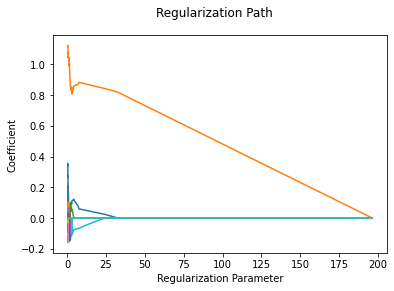

In [168]:
data = high_dim_dataset()
# data = simple_dataset()
regu_dantzig = Regularized_Dantzig(X1=data['X1'], Y1=data['Y1'],X2=data['X2'], Y2=data['Y2'])
weight = regu_dantzig.solve()


## LBI 求解
$min \|Z - G\beta\|_{\infty}^2 + \lambda \| \beta\|_1$

In [169]:
class LBI(object):
    def __init__(self, X1, Y1, X2, Y2):
        mean = np.mean(np.vstack([X1, X2]), 0)
        mean_y = np.mean(np.vstack([Y1, Y2]), 0)
        X1, X2 = X1-mean, X2-mean
        Y1, Y2 = Y1-mean_y, Y2-mean_y
        scale =   np.sqrt(np.mean(X1**2, 0)) +  np.sqrt(np.mean(X2**2, 0))
        scale /= 2
        self.X1=X1/scale
        self.Y1=Y1
        self.X2=X2/scale
        self.Y2=Y2
    def solve(self, kappa=100):
        # cal G and Z
        G = np.matmul(self.X1.transpose(), self.X1)/len(self.X1) -  np.matmul(self.X2.transpose(), self.X2)/len(self.X2)
        Z = np.matmul(self.X1.transpose(), self.Y1)/len(self.X1) -  np.matmul(self.X2.transpose(), self.Y2)/len(self.X2)
        G  = (G- np.mean(G,0 ))/np.std(G,0 )
        Z  = (Z- np.mean(Z, 0))/np.std(Z, 0)
        p = G.shape[1]
        weight = np.zeros((p,))
        kappa =kappa
        L_list = []
        n = G.shape[0]
        p = G.shape[1]
        weight = np.zeros((p,))
        z = np.zeros((p,))
        path = []
        selection_list  = []
        selection_epoch_list = []
        res = np.matmul(G, weight) - Z
        max_index = np.random.choice(np.where(np.abs(res) == np.abs(res).max())[0])
        H = np.matmul(G.transpose(), G/p)
        _,d,_ = np.linalg.svd(H)
        s = d[max_index]
        alpha =1/(s*kappa) 
        inf_n  = np.max(np.abs(res))
        ga = np.zeros(res.shape[0], )
        max_index = np.random.choice(np.where(np.abs(res) == np.abs(res).max())[0])
        ga[max_index] = np.sign(res[max_index])
        grad =  inf_n* (np.matmul(G.transpose(), ga).ravel())/p
        grad_m = np.max(np.abs(grad))
        z -= grad/grad_m
        count = 0 
        while True:
            res = np.matmul(G, weight) - Z
            max_index = np.random.choice(np.where(np.abs(res) == np.abs(res).max())[0])
            H = np.matmul(G.transpose(), G/p)
            _,d,_ = np.linalg.svd(H)
            s =d[max_index]
            alpha =1/(s*kappa) 
            L = np.linalg.norm((Z - np.matmul(G, weight)), np.inf)**2
            res = np.matmul(G, weight) - Z
            inf_n  = np.max(np.abs(res))
            ga = np.zeros(res.shape[0], )
            max_index = np.random.choice(np.where(np.abs(res) == np.abs(res).max())[0])
            ga[max_index] = np.sign(res[max_index])
            grad = 2* inf_n* (np.matmul(G.transpose(), ga).ravel())/p
            z = z  -alpha *grad
            weight = kappa * np.sign(z) * np.clip(np.abs(z)-1, 0,10000000)
            w_r = weight.ravel()
            non_zero_list = [k for k in range(len(w_r)) if w_r[k] !=0 ]
            for ke in non_zero_list:
                if ke not in selection_list:
                    selection_list.append(ke)
                    selection_epoch_list.append(count+1)
            count += 1
            L_list.append(L)
            path.append(weight)
            if count > 100:
                break
            if np.max(grad) < 1e-3:
                break
        print(weight)
        path = np.array(path)
#         print(path.shape)
        plt.figure()
        for i in range(path.shape[1]):
            if i==1:
                plt.plot(range(len(path[:,i])),path[:,i], label="causal_" + str(i))
                plt.legend()
            else:
                plt.plot(range(len(path[:,i])),path[:,i])
                
                
            
        plt.show()
            
        

[ 0.          0.44907114  0.          0.          0.          0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -0.         

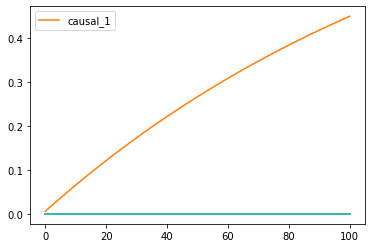

In [170]:
data = high_dim_dataset()
regu_dantzig = LBI(X1=data['X1'], Y1=data['Y1'],X2=data['X2'], Y2=data['Y2'])
weight = regu_dantzig.solve()


## 基于ISS求解的LBI
$min \|Z - G\beta\|_{\infty} + \lambda \| \beta\|_1$

In [171]:
class LBI_ISS(object):
    def __init__(self, X1, Y1, X2, Y2):
        mean = np.mean(np.vstack([X1, X2]), 0)
        mean_y = np.mean(np.vstack([Y1, Y2]), 0)
        X1, X2 = X1-mean, X2-mean
        Y1, Y2 = Y1-mean_y, Y2-mean_y
        scale =   np.sqrt(np.mean(X1**2, 0)) +  np.sqrt(np.mean(X2**2, 0))
        scale /= 2
        self.X1=X1/scale
        self.Y1=Y1
        self.X2=X2/scale
        self.Y2=Y2
    
    def update_t(self, rho, weight, grad):
        t=np.inf
        for i in range(len(grad)):
            if weight[i] > 0:
                t_tmp = (1 -rho[i])/grad[i]
                t = min(t_tmp, t)
            elif  weight[i] < 0:
                t_tmp = (-1 -rho[i])/grad[i]
                t = min(t_tmp, t)
            else:
                if grad[i] > 0:
                    t_tmp = (1 -rho[i])/grad[i]
                    t = min(t_tmp, t)
                elif grad[i] < 0:
                    t_tmp = (-1 -rho[i])/grad[i]
                    t = min(t_tmp, t)
                else:
                    if np.abs(rho[i]) > 1:
                        return None
        if t>0:
            return t
        else:
            return None
                  
    def solve(self, ):
        # cal G and Z
        G = np.matmul(self.X1.transpose(), self.X1)/len(self.X1) -  np.matmul(self.X2.transpose(), self.X2)/len(self.X2)
        Z = np.matmul(self.X1.transpose(), self.Y1)/len(self.X1) -  np.matmul(self.X2.transpose(), self.Y2)/len(self.X2)
        G  = (G- np.mean(G,0 ))/np.std(G,0 )
        Z  = (Z- np.mean(Z, 0))/np.std(Z, 0)
        p = G.shape[1]
        weight = np.zeros((p,))
        L_list = []
        n = G.shape[0]
        p = G.shape[1]
        path = []
        selection_list  = []
        selection_epoch_list = []
        count = 0
        t=[0]
        path.append(np.zeros(p,))
        rho = [np.zeros(p,)]
        while True:
            loss = np.linalg.norm(np.matmul(G, weight) - Z, np.inf)
            res = -np.matmul(G, weight) +Z
#             print("Residue", res)
#             print("Loss : ", loss)
            if loss < 1e-3:
                break
            max_index = np.random.choice(np.where(np.abs(res) == np.abs(res).max())[0])
            ga = np.zeros(res.shape[0], )
            
            max_index = np.random.choice(np.where(np.abs(res) == np.abs(res).max())[0])
            ga[max_index] = np.sign(res[max_index])
            grad = np.matmul(G.transpose(), ga).ravel()
            if np.max(np.abs(grad)) < 1e-5:
                print("Gradient : ", grad)
                break
            ## solve for t
            t_new = self.update_t(rho[count], weight, grad)
#             print("rho : ", rho[count])
#             print("grad : ", grad)
            if t_new == None or t_new == np.inf:
                print("Cannot Get Feasible t")
                print(weight)
                
                break
            print("t : ", t_new)
            if t_new < 1e-5:
                break
            t.append(t_new)
            rho_new = rho[count] + t_new * grad
            rho.append(rho_new)
            S_ind = [ i for i in range(len(rho_new)) if math.isclose(rho_new[i],1.0,rel_tol=1e-5) ]            
            if len(S_ind) == 0:
                break
            ### solve
            constraint= []
            G_new = G[:,S_ind]
            if len(S_ind) == 1:
                G_new = G_new.reshape(len(G), 1)
            one_vector = np.array(rho_new)[S_ind]
            beta = cp.Variable(len(S_ind))
            constraint.append(cp.multiply(beta, one_vector)>=0)
            prob = cp.Problem(cp.Minimize(cp.atoms.norm_inf(G_new@beta - Z)),
                 constraint)
            prob.solve()
            weight[S_ind] = np.array(beta.value).ravel()
            count += 1
#             print(weight)
            path.append(weight)
            
        the_list = np.array(path) 
        path = np.array(path)

        plt.figure()
        for i in range(path.shape[1]):
            if i in[1]:
                plt.plot(range(len(path[:,i])),path[:,i], label="causal_" + str(i))
                plt.legend()
            else:
                plt.plot(range(len(path[:,i])),path[:,i])
                
                
            
        plt.show()
            
     
        
        
        
        
        
        
   

t :  0.20659790429529487
Cannot Get Feasible t
[0.         0.96820688 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

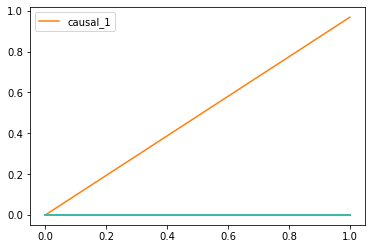

In [172]:
data = high_dim_dataset()
regu_dantzig = LBI_ISS(X1=data['X1'], Y1=data['Y1'],X2=data['X2'], Y2=data['Y2'])
regu_dantzig.solve()


 ## ISS 正常变量选择的例子
 $min \|Y - X\beta\|_{2}^2 + \lambda \| \beta\|_1$
 oracle set 为 index 对应 1 2 3  第 2 3 4 个

In [173]:
def simple_dataset_new(n=100, p=10):
    data ={}
    etay =  np.random.randn(n,)
    eta = np.random.randn(n,p)
    data['X1'] = eta
    data['Y1'] = eta[:,1] +etay + eta[:,2] + eta[:,3]
    
    return data

In [176]:
import copy
class LBI_ISS_L2(object):
    def __init__(self, X1, Y1):
        self.X1=X1
        self.Y1=Y1
   
    def update_t(self, rho, weight, grad):
        t=np.inf
        for i in range(len(grad)):
            if weight[i] > 0:
                if np.abs(grad[i]) > 1e-3:
                    t_tmp = (1 -rho[i])/grad[i]
                    t = min(t_tmp, t)
            elif  weight[i] < 0:
                if np.abs(grad[i]) > 1e-3:
                    t_tmp = (-1 -rho[i])/grad[i]
                    t = min(t_tmp, t)
            else:
                if grad[i] > 0:
                    t_tmp = (1 -rho[i])/grad[i]
                    t = min(t_tmp, t)
                elif grad[i] < 0:
                    t_tmp = (-1 -rho[i])/grad[i]
                    t = min(t_tmp, t)
                else:
                    if np.abs(rho[i]) > 1:
                        return None
        if t>0:
            return t
        else:
            return None
            
    def solve(self):
        # cal G and Z
        G = self.X1
        Z = self.Y1
        G  = (G- np.mean(G,0 ))/np.std(G,0 )
        Z  = (Z- np.mean(Z, 0))/np.std(Z, 0)
        p = G.shape[1]
        weight = np.zeros((p,))
        L_list = []
        n = G.shape[0]
        p = G.shape[1]
        weight = np.zeros((p,))
        path = []
        count = 0
        t=[0]
        rho = [np.zeros(p,)]
        while True:
            res =- np.matmul(G, weight) + Z
            max_index = np.random.choice(np.where(np.abs(res) == np.abs(res).max())[0])
            grad = np.matmul(G.transpose(), res).ravel()
            grad[np.abs(grad)<1e-3]=0

            if np.max(np.abs(grad)) < 1e-5:
                print("Gradient : ", grad)
                break
            ## solve for t
            t_new = self.update_t(rho[count], weight, grad)
            # print("rho : ", rho[count])
            # print("grad : ", grad)
            if t_new == None or t_new == np.inf:
                print("Cannot Get Feasible t")
#                 print(weight)
                break
            # print("t : ", t_new)
            if t_new < 1e-5:
                break
            t.append(t_new)
            rho_new = rho[count] + t_new * grad
            rho.append(rho_new)
            # print("rho : ", rho_new)
            S_ind = [ i for i in range(len(rho_new)) if math.isclose(rho_new[i],1.0,rel_tol=1e-5) ]            
            if len(S_ind) == 0:
                break
            ### solve
            constraint= []
            G_new = G[:,S_ind]
            if len(S_ind) == 1:
                G_new = G_new.reshape(len(G), 1)
            one_vector = np.array(rho_new)[S_ind]
            beta = cp.Variable(len(S_ind))
            constraint.append(cp.multiply(beta, one_vector)>=0)
            prob = cp.Problem(cp.Minimize(cp.atoms.norm2(G_new@beta - Z)),
                 constraint)
            prob.solve()
            
            weight[S_ind] = np.array(beta.value).ravel()
            count += 1
            weight_ = copy.deepcopy(weight)
            path.append(weight_)
        path = np.array(path)

        plt.figure()
        for i in range(path.shape[1]):
            if i in[1,2,3]:
                plt.plot(range(len(path[:,i])),path[:,i], label="causal_" + str(i))
                plt.legend()
            else:
                plt.plot(range(len(path[:,i])),path[:,i])
                
                
            
        plt.show()
            
     
        
        
        
        return weight

      

Cannot Get Feasible t


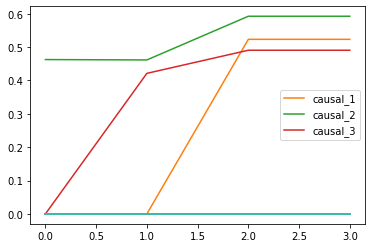

[0.         0.52344892 0.59262941 0.49070739 0.         0.
 0.         0.         0.         0.        ]


In [177]:
data = simple_dataset_new()
lbi = LBI_ISS_L2(X1=data['X1'], Y1=data['Y1'])
beta = lbi.solve()
print(beta)